# Laboratorio 3 - Segmentacion por Instancias

Nombre Completo: Juan Carlos Cerón Lombana
ID UAO: 2235516

Nombre Completo: Danny Mauricio Montero
ID UAO: 2244168

# Introduccion

La segmentación por instancias consiste en identificar objetos individuales en una imagen y segmentarlos del resto de la imagen.

El resultado de un modelo de segmentación de instancias es un conjunto de máscaras o contornos que delinean cada objeto de la imagen, junto con etiquetas de clase y puntuaciones de confianza para cada objeto. La segmentación de instancias es útil cuando se necesita saber no sólo dónde están los objetos en una imagen, sino también cuál es su forma exacta.

# Problema

La conservación de la biodiversidad es un reto crucial en el contexto actual de cambio climático y pérdida de hábitats naturales. Una de las estrategias más efectivas para monitorear y preservar la fauna salvaje es el uso de cámaras trampa. Estas cámaras permiten capturar imágenes y videos de diversas especies en su entorno natural sin interferencias humanas, proporcionando datos valiosos para los científicos y conservacionistas. Sin embargo, el análisis manual de estas imágenes puede ser una tarea ardua y propensa a errores.

Para abordar este desafío, la implementación de algoritmos de segmentación por instancia, como YOLOv8 (You Only Look Once), ofrece una solución prometedora. YOLOv8 es un modelo de detección y segmentación de objetos en tiempo real que permite identificar y clasificar cada instancia de las especies capturadas en las imágenes de las cámaras trampa con alta precisión y eficiencia. Al segmentar cada individuo en una imagen y diferenciar entre múltiples especies, el modelo facilita un análisis detallado y preciso de la biodiversidad en diferentes hábitats.

**Beneficios del Uso de YOLOv8 en la Conservación**

Identificación Precisa de Especies: Al utilizar YOLOv8, es posible identificar y clasificar con precisión a cada especie capturada en las cámaras trampa, proporcionando datos detallados sobre la presencia y el comportamiento de las diferentes especies.

Monitoreo Continuo: La capacidad de procesar imágenes en tiempo real permite un monitoreo continuo y eficiente de la fauna salvaje, detectando rápidamente cambios en las poblaciones y comportamientos de las especies.

Reducción de Errores Humanos: Automatizar el proceso de identificación y clasificación de especies minimiza los errores humanos, aumentando la fiabilidad de los datos recopilados.

Análisis de Tendencias a Largo Plazo: Con una base de datos extensa y precisa, los investigadores pueden analizar tendencias a largo plazo en la población y distribución de las especies, ayudando a tomar decisiones informadas para la conservación de la biodiversidad.


###Instalación de librerías

In [3]:
!pip install tensorflow matplotlib roboflow mrcnn
!pip install albumentations
#!pip install opencv-python-headless
!pip install scikit-image
!pip install ultralytics==8.0.196
!pip install opencv-python

   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   - -------------------------------------- 14.7/390.3 MB 71.0 MB/s eta 0:00:06
   --- ------------------------------------ 34.6/390.3 MB 81.6 MB/s eta 0:00:05
   ----- ---------------------------------- 53.2/390.3 MB 84.7 MB/s eta 0:00:04
   ------- -------------------------------- 72.6/390.3 MB 89.1 MB/s eta 0:00:04
   --------- ------------------------------ 94.6/390.3 MB 91.5 MB/s eta 0:00:04
   ----------- --------------------------- 111.4/390.3 MB 88.9 MB/s eta 0:00:04
   ----------- --------------------------- 119.0/390.3 MB 81.7 MB/s eta 0:00:04
   ------------- ------------------------- 137.1/390.3 MB 81.9 MB/s eta 0:00:04
   --------------- ----------------------- 150.2/390.3 MB 79.3 MB/s eta 0:00:04
   ---------------- ---------------------- 163.1/390.3 MB 77.2 MB/s eta 0:00:03
   ----------------- --------------------- 176.2/390.3 MB 76.6 MB/s eta 0:00:03
   ------------------ -------------------- 181.4/

In [4]:
#Librerías
import roboflow
import os
import cv2
import ultralytics
from ultralytics import YOLO
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import torch
import subprocess
import pkg_resources

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html


In [5]:
def uninstall_package(package_name):
    """
    desinstalar una libreria si existe
    """
    try:
        # Verificar si el paquete está instalado
        dist = pkg_resources.get_distribution(package_name)
        print(f"{package_name} está instalado. Procediendo a desinstalar...")
        
        # Desinstalar el paquete
        subprocess.check_call(["pip", "uninstall", "-y", package_name])
        print(f"{package_name} ha sido desinstalado con éxito.")
        
    except pkg_resources.DistributionNotFound:
        print(f"{package_name} no está instalado.")

###Descargamos el Dataset desde Roboflow

In [6]:
# Inicializar el objeto de Roboflow
rf = roboflow.Roboflow(api_key="ePKlGvWr1xfAErIigf0D")

# Obtener el proyecto y la versión
project = rf.workspace("jcceron").project("laboratorio_3")
version = project.version(2)

# Definir una ruta para la descarga
output_dir = "C:\\datasets\\laboratorio_3"
os.makedirs(output_dir, exist_ok=True)

# Descargar el dataset en formato YOLOv8
dataset = version.download("yolov8", location=output_dir, overwrite=True)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to C:\datasets\laboratorio_3 in yolov8:: 100%|██████████| 260/260 [00:00<00:00, 794.93it/s]


## Investigación y Explicación de Métricas

### Métricas para detección y segmentación por instancias

- Precisión (Accuracy)

La precisión es la proporción de predicciónes correctas entre el total de predicciones realizadas.  Esta métrica puede ser engañosa en datasets desbalanceados.
Esta métrica se obtiene con:

Accuracy = Número de predicciones correctas/ Número total de predicciones.

- Índice de similitud de Jaccard (IoU - Intersection over Union)
IoU es una métrica que mide la coincidencia entre el bounding box predicho y el bounding box real. 
Esta métrica se obteine con:

IoU = área de intersección / área de unión.

Su interpretación corresponde a:
1 significa una coincidencia perfecta. Generalmente, se considera una predicción correcta si el IoU es mayor que 0.5.

- AP (Average Precisión)
Se calcula con el promedio de precisión calculado en diferentes umbrales de IoU.

- mAP (mean Average Precisión)
Es el promedio de AP para todas las clases del dataset utilizado


###4. Segmentación por Instancias de al menos dos objetos distintos

- Creación del Dataset
Se realizó el dataset a través de la aplicación Roboflow, donde realizamos un etiquetado manual, a través de esta aplicación se creó y etiquetó un dataset propio con más de 20 imágenes por clase correspondiente a animales de granja (caballo, gallina, perro, gato)

- Entrenamiento
Se usará Mask R-CNN para entrenar el modelo de segmentación.

In [7]:
# Definir la ruta a la carpeta de imágenes exportadas desde Roboflow
image_folder = "C:/datasets/Laboratorio_3/train/images"

# Verificar si la carpeta existe
if not os.path.exists(image_folder):
    print(f"Error: La carpeta '{image_folder}' no existe.")
else:
    # Obtener una lista de todas las imágenes en la carpeta
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Verificar si hay imágenes en la carpeta
    if not image_files:
        print(f"No se encontraron imágenes en la carpeta '{image_folder}'.")
    else:
        # Verificar el tamaño de las primeras 5 imágenes
        for image_file in image_files[:5]:
            image_path = os.path.join(image_folder, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                height, width, _ = image.shape
                print(f"{image_file}: {width}x{height} píxeles")
            else:
                print(f"Error: No se pudo cargar la imagen '{image_file}'. Verifica que el archivo no esté corrupto.")


1213_jpg.rf.ad2f9c775d4fe6a0f290c06566af5c82.jpg: 640x640 píxeles
1213_jpg.rf.ceb687d6cf69eb24f275c9715e69a376.jpg: 640x640 píxeles
1213_jpg.rf.f4494f8b1a067d8d8a01ec714a541974.jpg: 640x640 píxeles
1219_jpeg.rf.077de2f66df2ed9d7def4769563c8df0.jpg: 640x640 píxeles
1219_jpeg.rf.9d3b46748108893ea0f86e59fb86c7e1.jpg: 640x640 píxeles


In [8]:
!pip show ultralytics

Name: ultralytics
Version: 8.0.196
Summary: Ultralytics YOLOv8 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://github.com/ultralytics/ultralytics
Author: Ultralytics
Author-email: hello@ultralytics.com
License: AGPL-3.0
Location: C:\Users\dmontero\Documents\Laboratorio3\lab3\Lib\site-packages
Requires: matplotlib, numpy, opencv-python, pandas, pillow, psutil, py-cpuinfo, pyyaml, requests, scipy, seaborn, thop, torch, torchvision, tqdm
Required-by: 


In [9]:
ultralytics.checks()

Ultralytics YOLOv8.0.196  Python-3.12.8 torch-2.5.1+cpu CPU (Intel Xeon W-2145 3.70GHz)
Setup complete  (16 CPUs, 63.6 GB RAM, 293.7/475.9 GB disk)


TASK (si no se coloca la infiere del dataset) --> detect, segment, classify, pose.
MODE --> train, val, predict, track (obligatorio)
ARGS --> por ejemplo tamñao de imagen imgsz=320.


In [10]:
HOME = os.getcwd()
print(HOME)
ubicacion = HOME
print(f"Mi ubicación actual es: {ubicacion}")

ubicacion_data = {dataset.location}
print(ubicacion_data)

c:\Users\dmontero\Documents\Laboratorio3
Mi ubicación actual es: c:\Users\dmontero\Documents\Laboratorio3
{'C:\\datasets\\laboratorio_3'}


In [17]:
!yolo task=segment mode=train model=yolov8n-seg.pt data={dataset.location}/data.yaml  epochs=20 imgsz=640 verbose=True

# !yolo task=segment mode=train model=yolov8n-seg.pt data={dataset.location}/data.yaml epochs=20 imgsz=640 verbose=True
#yolo task=segment mode=train model=yolov8n-seg.pt data={dataset.location}/data.yaml epochs=50 imgsz=640 --stream
#python train.py task=detect mode=train

c:\Users\dmontero\Documents\Laboratorio3\lab3\Lib\site-packages\ultralytics\nn\tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_locati

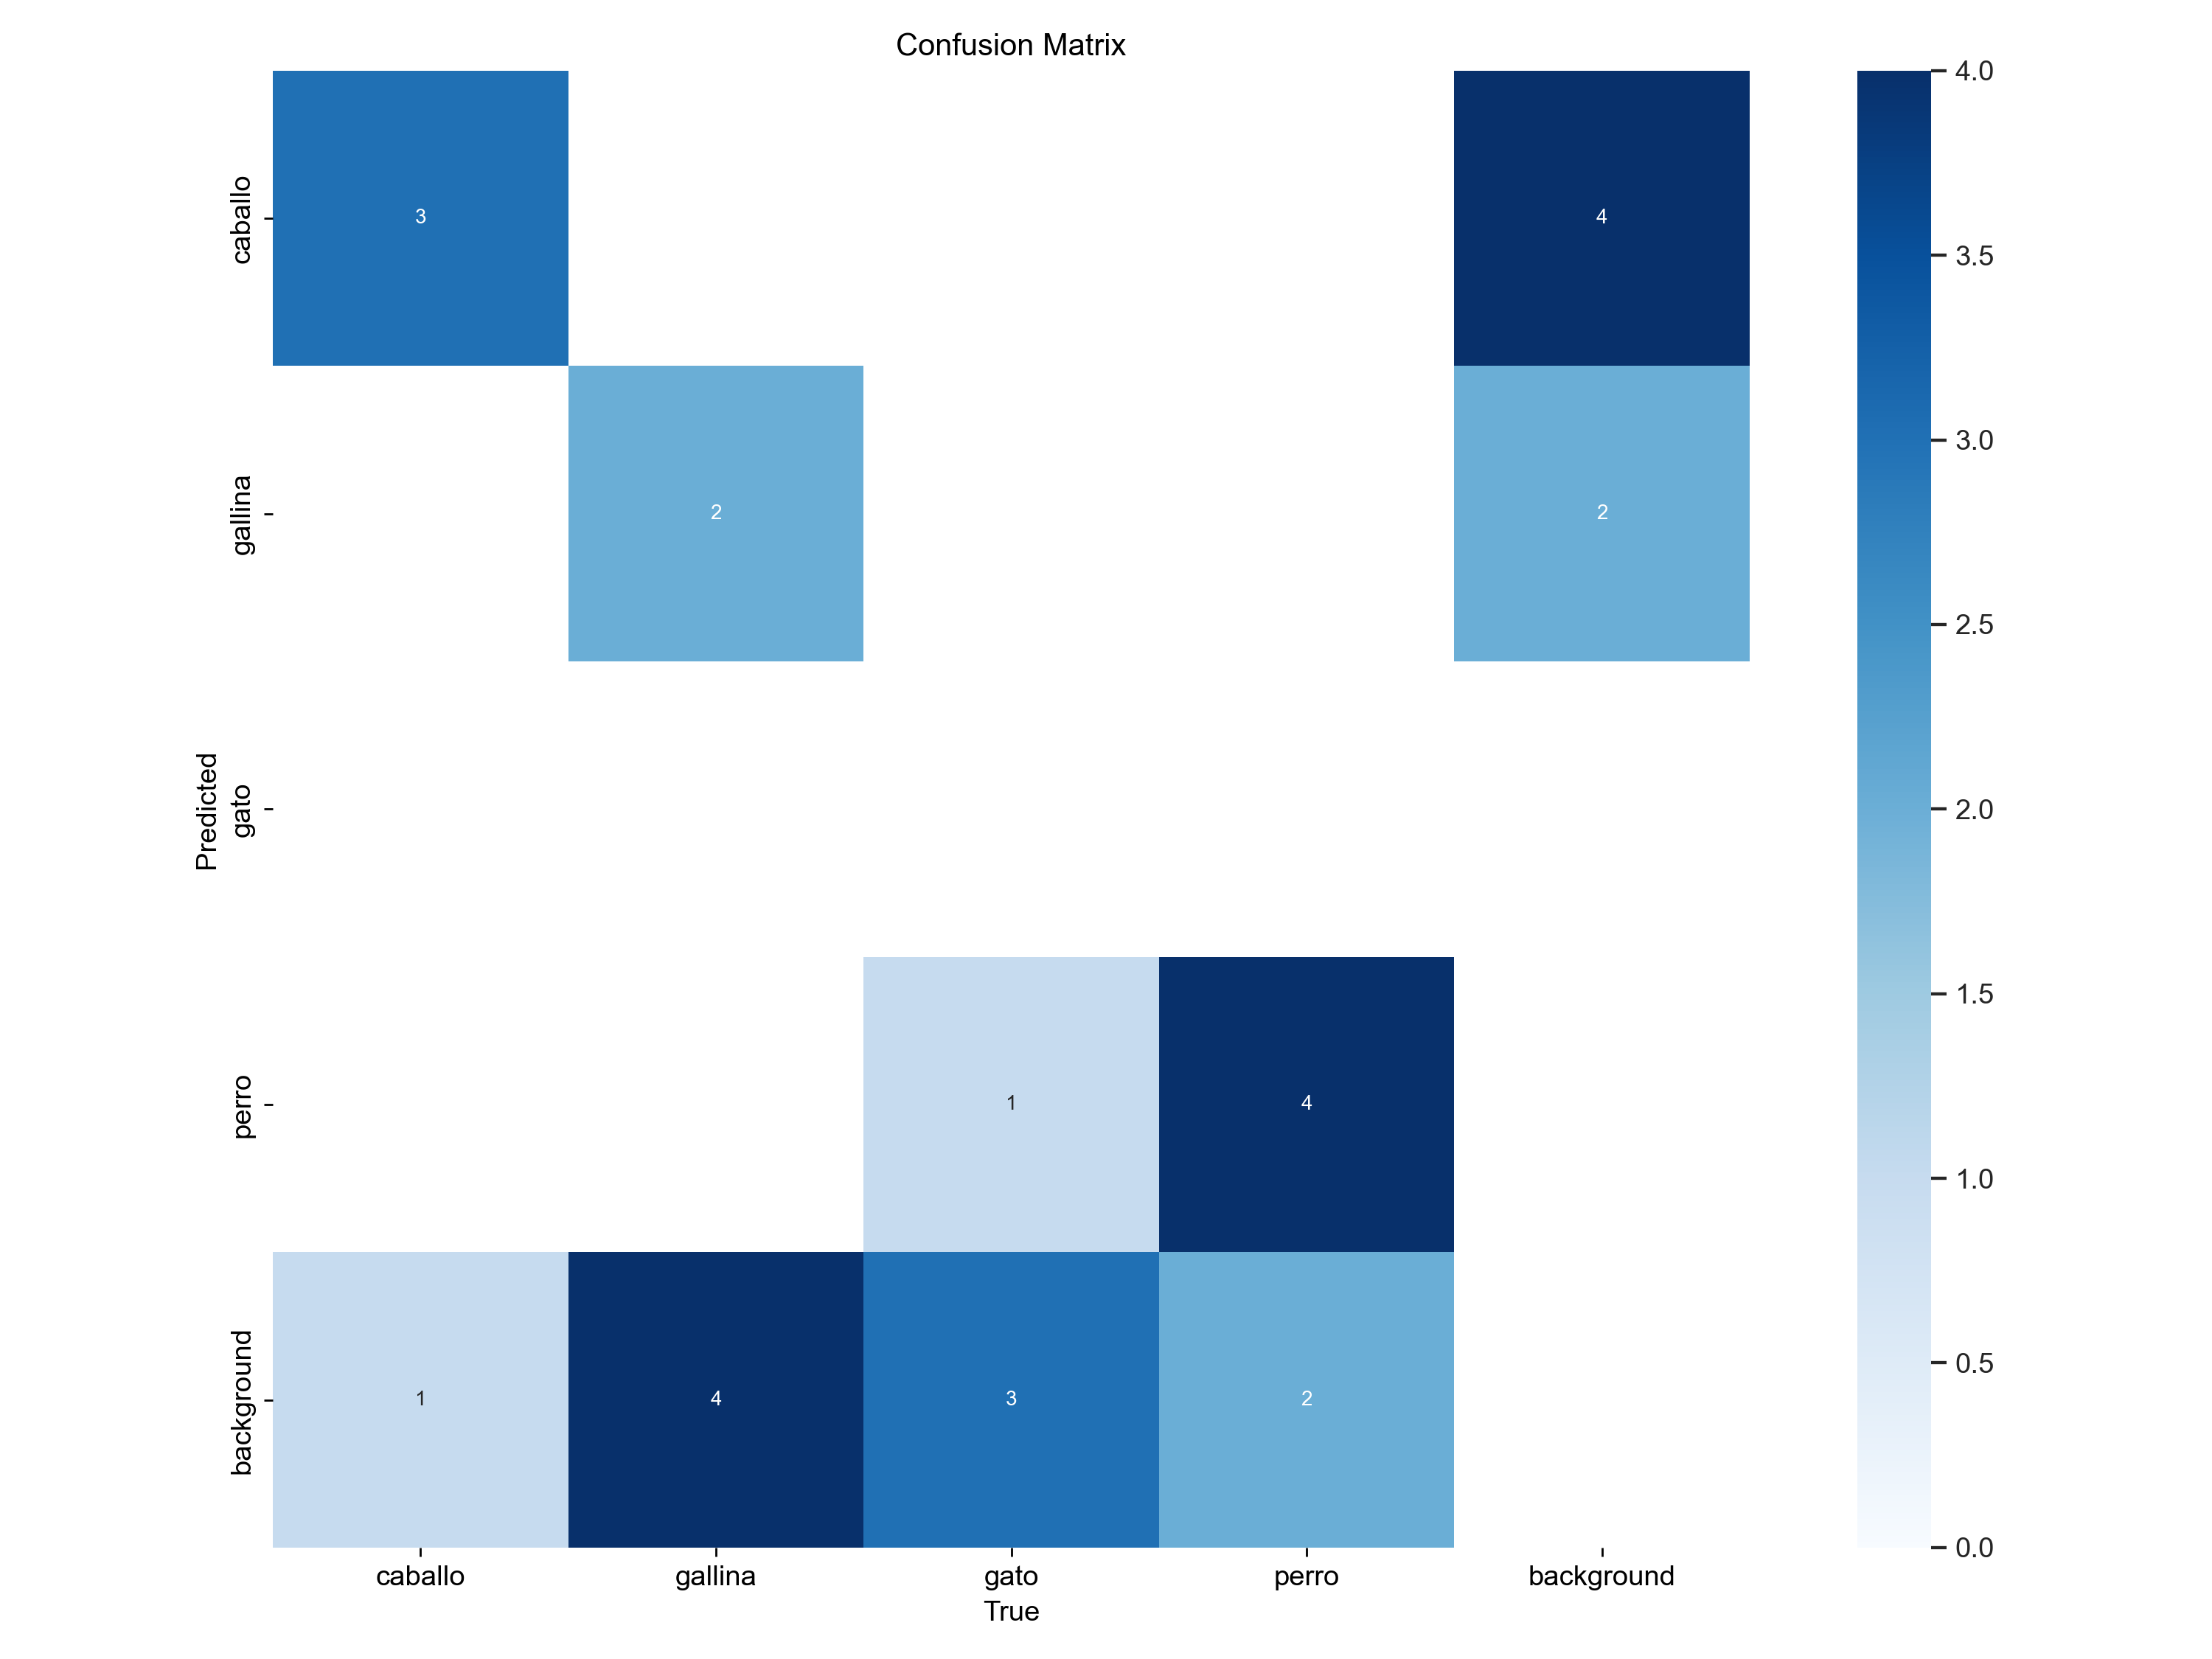

In [19]:
# Mostrar la matriz de confusión
Image(filename=f'{HOME}/runs/segment/train5/confusion_matrix.png', width=600)

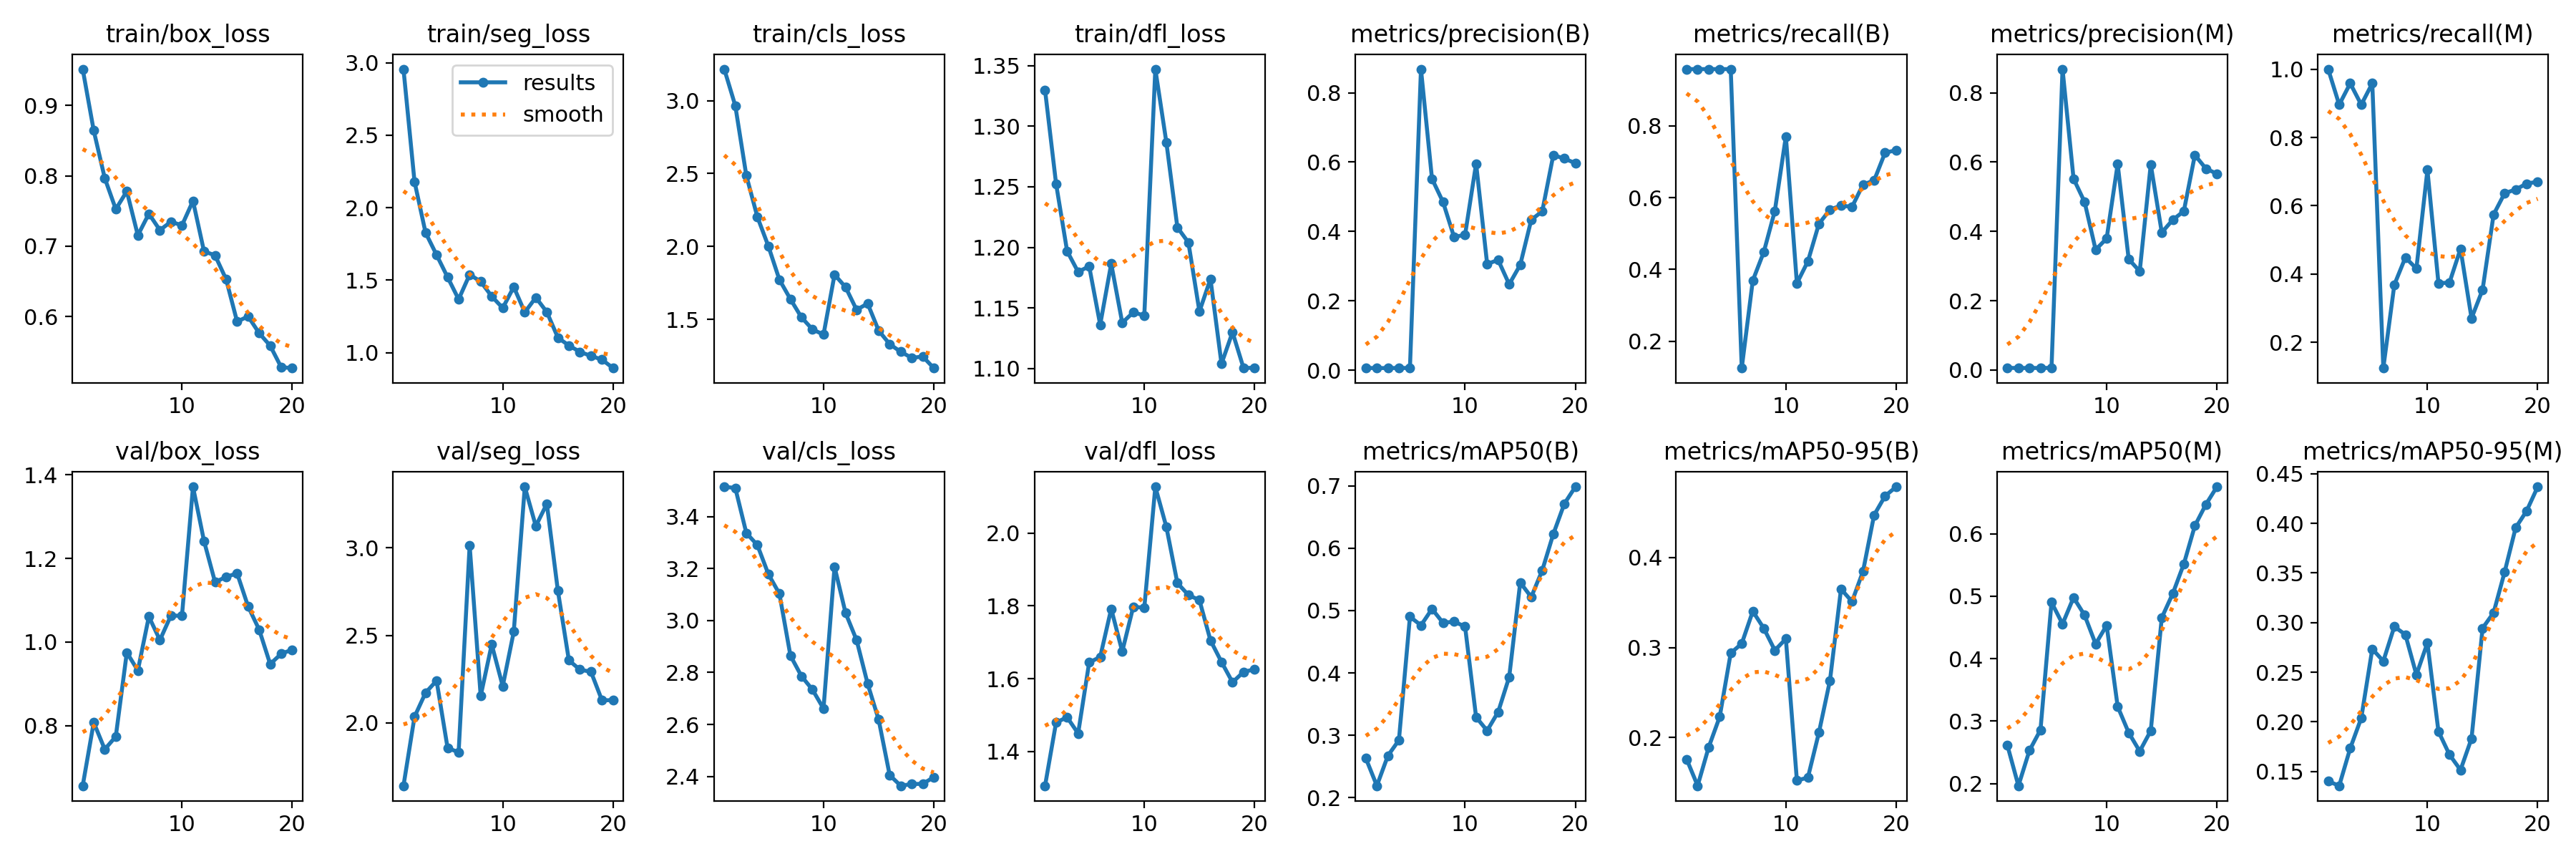

In [21]:
# Mostrar resultados de entrenamiento
Image(filename=f'{HOME}/runs/segment/train5/results.png')

-Detección

In [22]:
!pip show opencv-python

Name: opencv-python
Version: 4.10.0.84
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/opencv/opencv-python
Author: 
Author-email: 
License: Apache 2.0
Location: C:\Users\dmontero\Documents\Laboratorio3\lab3\Lib\site-packages
Requires: numpy
Required-by: ultralytics


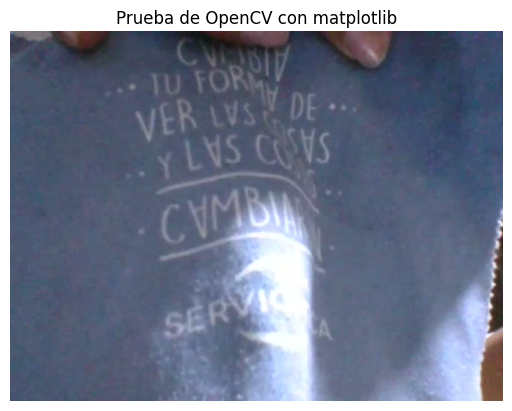

In [35]:
#Prueba de activación de la cámara

# Capturar video desde la cámara
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: No se pudo abrir la cámara.")
else:
    ret, frame = cap.read()
    if ret:
        # Convertir de BGR a RGB para matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Mostrar la imagen con matplotlib
        plt.imshow(frame_rgb)
        plt.title('Prueba de OpenCV con matplotlib')
        plt.axis('off')
        plt.show()
    else:
        print("Error: No se pudo capturar el frame.")

cap.release()


### Procesamiento clásico de Imagenes
Se realizan dos tipos de procesamiento de las imágenes al código anterior.
- Filtro de Detección de bordes (Sobel)
- Cambio de Color a Escala de Grises

In [29]:
#Instalamos la versión estándar de OpenCV, desinstalando OpenCV-python-headless
#!pip install opencv-python

#Se desinstala si existe porque genera conflictos
uninstall_package('opencv-python-headless')

opencv-python-headless está instalado. Procediendo a desinstalar...
opencv-python-headless ha sido desinstalado con éxito.


In [30]:
!pip list | findstr opencv

opencv-python           4.10.0.84


In [32]:
#Obtención de segmentación en tiempo real

# Obtener la ruta actual de trabajo
HOME = os.getcwd()

# Cargar el modelo YOLOv8 previamente entrenado después del Data Augmentation
model_path = f"{HOME}/runs/segment/train5/weights/best.pt"  # Asegúrate de que esta ruta es correcta
model = YOLO(model_path)

# Iniciar la captura de video desde la cámara (0 = cámara por defecto)
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: No se pudo abrir la cámara.")
    exit()

# Configurar matplotlib para modo interactivo
plt.ion()
fig, ax = plt.subplots(figsize=(10, 6))

# Bucle para capturar video continuamente
while True:
    # Capturar un frame de la cámaraQ
    ret, frame = cap.read()
    if not ret:
        print("Error: No se pudo capturar el frame.")
        break

    # Redimensionar el frame para garantizar un tamaño compatible con el modelo (por ejemplo, 640x640)
    resized_frame = cv2.resize(frame, (640, 640))

    # Realizar la predicción de segmentación
    results = model.predict(resized_frame, conf=0.25, iou=0.5, verbose=False)

    # Extraer la cantidad de instancias detectadas
    num_instances = len(results[0].boxes)
    print(f"Cantidad de instancias detectadas: {num_instances}")

    # Dibujar las segmentaciones en el frame
    annotated_frame = results[0].plot()

    # Mostrar el frame anotado con OpenCV
    cv2.imshow("Segmentación en Tiempo Real", annotated_frame)

    # Salir del bucle con la tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar la cámara y cerrar las ventanas
cap.release()
cv2.destroyAllWindows()
plt.close()

Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 2
Cantidad de instancias detectadas: 2
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 2
Cantidad de instancias detectadas: 2
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 1
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
Cantidad de instancias detectadas: 0
C